<h1>Chord Estimation</h1>
<br>
In this Notebook we are going to explore a different representation for the chords, similarly as used in a paper from mirex
<br>

In [193]:
import sys
# do this only once
sys.path.append('./src/audio_processing/')
sys.path.append('./src/data_processing/')
sys.path.append('./src/chord_parser/')
sys.path.append('./src/metrics/')

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#python input/output and regex
import re
import os
from pathlib import Path

#chord info
import pychord as pc

#signal processing libraries
from scipy.io import wavfile
from scipy import signal

#sklearn for normalization
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#tensorflow
import tensorflow as tf
from tensorflow import keras

#librosa
import librosa
import librosa.display

#import custom modules
import filters
import spectrograms
import audiofiles
from annotation_processing import chords_to_onehot

## CQT
- number of bins = 192
- bins per octave = 24
- sample rate = 22050 Hz
- min frequency = C1 (~31Hz)
- hop_length = 2048

In [195]:
nbins=192
bins_per_octave=24
hop_length=2048
audiofiles_path = 'Audiofiles/The Beatles'
input_features = nbins

Spectrograms = {'The Beatles': {}}
Timestamps = {'The Beatles': {}}

In [196]:
## cqt on isophonics
for filename in Path(audiofiles_path).glob('**/*.wav'):

    path, track = os.path.split(filename)
    path, album = os.path.split(path)

    track_no = re.search('([0-9].).', track).group(1)

    # read wav and create spectrogram
    track, sample_rate = librosa.load(filename, sr = 22050)
    track_time = librosa.get_duration(y=track, sr=sample_rate)
#     n_fft = int(track_time // (hop_length / sample_rate))
    
    spectrogram = librosa.cqt(track, sr=sample_rate, n_bins=nbins, bins_per_octave=bins_per_octave, hop_length=hop_length)

    frames = list(range(0, spectrogram.shape[1]))
    times = librosa.frames_to_time(frames, sr=sample_rate, hop_length=hop_length)

    if album not in Spectrograms['The Beatles']:
        Spectrograms['The Beatles'][album] = {}
        Timestamps['The Beatles'][album] = {}

    Spectrograms['The Beatles'][album][track_no] = librosa.amplitude_to_db(abs(spectrogram), ref=np.max).T
    Timestamps['The Beatles'][album][track_no] = times

In [197]:
input_features = nbins
Timeseries = Spectrograms
Artist = 'The Beatles'
# Scale Spectrogram Data
for album in Timeseries[Artist].keys():
    for track_no in Timeseries[Artist][album]:
        Timeseries[Artist][album][track_no] += 80

Only if in possesion of billboard **GLOBAL z-normalization**

In [36]:
## OPTIONAL !!

global_Scaler = StandardScaler()

for artist in Timeseries.keys():
    for album in Timeseries[artist].keys():
        for track_no, track_data in Timeseries[artist][album].items():
            global_Scaler.fit(track_data)
            
for track_no, track_data in Timeseries_Billboard.items():
    global_Scaler.fit(track_data)
            
for artist in Timeseries.keys():
    for album in Timeseries[artist].keys():
        for track_no, track_data in Timeseries[artist][album].items():
            Timeseries[artist][album][track_no] = global_Scaler.transform(track_data)
            
for track_no, track_data in Timeseries_Billboard.items():
    Timeseries_Billboard[track_no] = global_Scaler.transform(track_data)

<h3>Loading Datasets</h3>

#### Isophonics

In [198]:
### get all chordlab files
Chordlab = {'The Beatles': {}}
for filename in Path('Big-Dataset/The Beatles').glob('**/scratch/**/*.lab'):
    
    path, track = os.path.split(filename)
    path, album = os.path.split(path)
    track_no = re.search('([0-9].)_-_',track).group(1)
    
    if (album not in Chordlab['The Beatles']): 
        Chordlab['The Beatles'][album] = {}
        
    Chordlab['The Beatles'][album][track_no] = pd.read_csv(filename, names=['Starts', 'Ends', 'Chord'], sep=' ', header=None)

<h3>Chord Vocab</h3>

In [199]:
### Load all chords in a dictionary
Chords = []
Appearances = {}
for album in Chordlab['The Beatles'].keys():
    for track_no in Chordlab['The Beatles'][album].keys():
        for index, row in Chordlab['The Beatles'][album][track_no].iterrows():
            if row['Chord'] not in Chords: 
                Chords.append(row['Chord'])
                Appearances[row['Chord']] = 0
            else: 
                Appearances[row['Chord']] += 1
            
### How many chords do we have in our dataset?
print ("Unique Chords in our Dataset: ",len(Chords))

Unique Chords in our Dataset:  407


In [200]:
Major_Chords = 0
Minor_Chords = 0

for chord in Chords:
    if chord.find('min') != -1:
        Minor_Chords += Appearances[chord]
    else:
        Major_Chords += Appearances[chord]
        
print ('Major Chords: ', Major_Chords, '\nMinor Chords: ', Minor_Chords)

Major Chords:  11361 
Minor Chords:  2853


Major Chords = 4*Minor Chords -> 
1. We need to increment the number of minor chords
2. Or we can punish harder for the predictions on minor chords

## Dataset Annotations Transformation

In [201]:
ChordLib = {'C' : 0, 'C#': 1, 'Db' : 1, 'D' : 2, 'D#' : 3, 'Eb' : 3, 'E' : 4, 'Fb' : 4, 'F' : 5, 'F#' : 6, 'Gb' : 6, 'G' : 7, 'G#' : 8, 'Ab' : 8, 'A' : 9, 'A#' : 10, 'Bb' : 10, 'B' : 11, 'Cb' : 11, 'N' : 12, 'X' : 13}

<img src="images/intervals.png" width="400" />

<caption><center> <b>Figure 2</b>: Semitones to Intervals.</center></caption>

In [202]:
def Semitonize(interval, mode):
    if interval == '0':
        return 0
    
    if mode == 'Major':
        if interval == '2':
            return 2
        elif interval == 'b2':
            return 1
        if interval == '3':
            return 4
        elif interval == 'b3':
            return 3
        if interval == '5':
            return 7
        elif interval == 'b5':
            return 6
        if interval == '6':
            return 9
        elif interval == 'b6':
            return 8
        if interval == '7':
            return 10
        elif interval == 'b7':
            return 10
        if interval == '9':
            return 13
        else:
            return 0
    elif mode == 'Minor':
        if interval == '2':
            return 2
        elif interval == 'b2':
            return 1
        if interval == '3':
            return 4
        elif interval == 'b3':
            return 3
        if interval == '5':
            return 7
        elif interval == 'b5':
            return 6
        if interval == '7':
            return 10
        elif interval == 'b7':
            return 10
    elif mode == 'Dim':
        if interval == '2':
            return 2
        elif interval == 'b2':
            return 1
        if interval == '3':
            return 4
        elif interval == 'b3':
            return 3
        if interval == '5':
            return 7
        elif interval == 'b5':
            return 6
        if interval == '7':
            return 10
        elif interval == 'b7':
            return 10
        else:
            return 0
    elif mode == 'Aug':
        if interval == '2':
            return 2
        elif interval == 'b2':
            return 1
        if interval == '3':
            return 4
        elif interval == 'b3':
            return 3
        if interval == '5':
            return 7
        elif interval == 'b5':
            return 6
        if interval == '7':
            return 10
        elif interval == 'b7':
            return 10
        else:
            return 0
    else:
        return 0

In [203]:
Fourths = {'N' : 0, 'dominant7' : 1, 'minor7' : 2, 'major7' : 3, 'major6' : 4, 'X' : 5}
Triads = {'N' : 0, 'Major' : 1, 'Minor' : 2, 'Dim' : 3, 'Aug' : 4, 'Sus2' : 5, 'Sus4' : 6, 'X' : 7}

In [204]:
def parse_chords(Chords, df):
    # silence
    df['Root'].append(ChordLib['N'])        
    df['Unknown'].append(0)
    df['Triad'].append(Triads['N'])
    df['Fourth Note'].append(Fourths['N'])
    # for all chords in vocab
    for chord in Chords:
        if chord == 'N':
            continue
        # print('* Chord: ', chord)
        Mode = 'Major'
        fourth_note = ''
        fourth_note_mode = ''
        Unknown = False
        # discard inversion if exists
        if chord.find('/') != -1:
            chord, _ = chord.split('/')
        
        if chord == 'X':
            root = chord
            Unknown = True
            
        if chord.find(':') != -1:
            root, chord = chord.split(':')
            if chord[:3] == 'min':
                Mode = 'Minor'
                if chord != 'min':
                    if chord[3] == '7':
                        fourth_note = '7'
                        fourth_note_mode = 'minor'
                    if chord[3] == '(':
                        Unknown = True
            elif chord[:3] == 'dim':
                Mode = 'Dim'
                if chord != 'dim':
                    fourth_note = chord[3]
                    fourth_note_mode = 'dominant'
            elif chord[:3] == 'aug':
                Mode = 'Aug'
                if chord != 'aug':
                    fourth_note = chord[3]
                    fourth_note_mode = 'major'
            elif chord[:3] == 'maj':
                Mode = 'Major'
                fourth_note_mode = 'major'
                if chord != 'maj':
                    chord = chord[3:]
                    fourth_note = chord[0]
                    if fourth_note == '(':
                        Unknown = True
            elif chord[:4] == 'sus2':
                Mode = 'Sus2'
            elif chord[:4] == 'sus4':
                Mode = 'Sus4'
            elif chord[:4] == 'sus7':
                Mode = 'Sus4'
                fourth_note = '7'
                fourth_note_mode = 'dominant'
            elif chord[:4] == 'sus9':
                Mode = 'Sus4'
                fourth_note = '7'
                fourth_note_mode = 'dominant'
                Unknown = True
            elif chord[:4] == 'hdim':
                #half diminished
                Mode ='Dim'
                fourth_note_mode = 'minor'
                fourth_note = chord[4]
            elif chord[:4] == '7':
                #Dominant seventh
                Mode = 'Major'
                fourth_note = chord[0]
                fourth_note_mode = 'dominant'
                if fourth_note == '(':
                    Unknown = True
            else:
                Unknown = True
            if chord.find('(') != -1:
                Unknown = True
        else:
            root = chord

        if not Unknown:
            #print(root, bass, Mode, fourth_note)
            df['Root'].append(ChordLib[root])        
            df['Unknown'].append(0)
            df['Triad'].append(Triads[Mode])
            if (fourth_note != '7' and fourth_note != '6'):
                fourth_note = 'N'
                fourth_note_mode = ''
            df['Fourth Note'].append(Fourths[fourth_note_mode + fourth_note])
        else:
            #print ('Unknown')
            df['Root'].append(ChordLib[root])        
            df['Unknown'].append(1)
            df['Triad'].append(Triads[Mode])
            df['Fourth Note'].append(Fourths['X'])
        #print('-----')

In [205]:
df = pd.DataFrame(columns=('Root', 'Unknown', 'Triad', 'Fourth Note'))
representations = {'Root' : [], 'Unknown' : [], 'Triad' : [], 'Fourth Note' : []}

In [206]:
parse_chords(Chords, representations)

**Convert the dictionary to dataframe**

In [207]:
df = pd.DataFrame(data=representations, index=Chords).rename_axis('Chord', axis = 1)
df.iloc[0:40]

Chord,Root,Unknown,Triad,Fourth Note
N,12,0,0,0
F:maj6,5,0,1,4
C,0,0,1,0
G,7,0,1,0
A:min,9,0,2,0
D:min7/4,2,0,2,2
F:maj/9,5,0,1,0
C/7,0,0,1,0
C/5,0,0,1,0
F,5,0,1,0


Now this is a dictionary for every chord<br>
I'm going to index every chord with its timestep just liek before, but instead of a one hot of size 407, we will have the above representation<br>

## Preprocessing

In [208]:
encoder = OneHotEncoder(categories='auto')
encoder.fit(np.array(list(range(0,14))).reshape(-1,1))

OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

In [209]:
encoder_triads = OneHotEncoder(categories='auto')
encoder_triads.fit(np.array(list(range(0,8))).reshape(-1,1))

OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

In [210]:
encoder_fourth = OneHotEncoder(categories='auto')
encoder_fourth.fit(np.array(list(range(0,6))).reshape(-1,1))

OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

In [211]:
### Annotations
Artist='The Beatles'
root_vec = {}
quality_vec = {}
for album in Chordlab[Artist].keys():
    root_vec[album] = {}
    quality_vec[album] = {}
    for track_no in Chordlab[Artist][album].keys():
        df_rows = Chordlab[Artist][album][track_no].itertuples()
        index = 0
        max_len = len(Chordlab[Artist][album][track_no])
        root = np.empty((14,))
        quality = np.empty((15,)) # 1 + 8 + 6
        row = next(df_rows)
        for timestamp in Timestamps[Artist][album][track_no]:
            if ((index + 1) < max_len) & (timestamp >= row[2]):
                index += 1
                row = next(df_rows)
            root = np.column_stack((root, encoder.transform([[df.loc[row[3]]['Root']]]).toarray()[0]))
            quality = np.column_stack((quality, np.append(np.append(df.loc[row[3]][1], encoder_triads.transform([[df.loc[row[3]][2]]]).toarray()[0]), encoder_fourth.transform([[df.loc[row[3]][3]]]).toarray()[0])))
        root_vec[album][track_no] = root
        quality_vec[album][track_no] = quality
    print(album, ' completed')

09_-_Magical_Mystery_Tour  completed
12_-_Let_It_Be  completed
04_-_Beatles_for_Sale  completed
10CD2_-_The_Beatles  completed
05_-_Help!  completed
03_-_A_Hard_Day's_Night  completed
07_-_Revolver  completed
10CD1_-_The_Beatles  completed
08_-_Sgt._Pepper's_Lonely_Hearts_Club_Band  completed
01_-_Please_Please_Me  completed
06_-_Rubber_Soul  completed
11_-_Abbey_Road  completed
02_-_With_the_Beatles  completed


In [212]:
# Take care fo the one extra row in the beginning of the array
for album in root_vec.keys():
    for track_no in root_vec[album].keys():
        root_vec[album][track_no] = np.delete(root_vec[album][track_no], 0, 1)
        quality_vec[album][track_no] = np.delete(quality_vec[album][track_no], 0, 1)

In [104]:
### STORE
import pickle

with open('root_vec.pickle', 'wb') as handle:
    pickle.dump(root_vec, handle, protocol=pickle.HIGHEST_PROTOCOL)  
    
with open('quality_vec.pickle', 'wb') as handle:
    pickle.dump(quality_vec, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
### LOAD
import pickle

with open('root_vec.pickle', 'rb') as handle:
    root_vec = pickle.load(handle)
    
with open('quality_vec.pickle', 'rb') as handle:
    quality_vec = pickle.load(handle)

#### Constructing numpy arrays
chunk_size = slicing window (~10 secs)
<br>
input_features = nbins

In [213]:
# test track
test_track_no = '02'
album_test_track = '07_-_Revolver'
# validation album
album_validate = '10CD1_-_The_Beatles'

In [222]:
chunk_size = 300

In [223]:
# train set
x_train = np.zeros((1,chunk_size,input_features)) #num of frequencies
y_train_root = np.zeros((1,chunk_size,14))
# test set
x_test = np.zeros((1,chunk_size,input_features)) #num of frequencies
y_test_root = np.zeros((1,chunk_size,14))
# validation set
x_val = np.zeros((1,chunk_size,input_features)) #num of frequencies
y_val_root = np.zeros((1,chunk_size,14))

for album in root_vec.keys():
    if album.find(album_validate) != -1:
        continue
    for track_no in root_vec[album].keys():
        timestep = 0
        # size of the current track
        chunks = root_vec[album][track_no].T.shape[0]
        # track frequencies
        timeseries = Timeseries['The Beatles'][album][track_no]
        # track annotations
        annotations = root_vec[album][track_no].T
        # slice and stack train-test data
        if track_no.find(test_track_no) == -1 or album.find(album_test_track) == -1:
            # train tracks
            while timestep < chunks :
                if (chunks - timestep) > chunk_size:
                    batch_x = np.resize(timeseries[timestep:timestep+chunk_size,:], (1, chunk_size, input_features)) #num of frequencies
                    x_train = np.append(x_train, batch_x, axis = 0)
                    batch_y = np.resize(annotations[timestep:timestep+chunk_size,:], (1, chunk_size, 14))
                    y_train_root = np.append(y_train_root, batch_y, axis = 0)
                else:
                    batch_x = timeseries[timestep:,:]
                    batch_y = annotations[timestep:,:]
                    for step in range (0, chunk_size + timestep - chunks):
                        batch_x = np.vstack((batch_x, np.zeros((1,input_features))))
                        batch_y = np.vstack((batch_y, encoder.transform([[df.loc['N']['Root']]]).toarray()[0]))
                    x_train = np.append(x_train, np.array([batch_x]), axis = 0)
                    y_train_root = np.append(y_train_root, np.array([batch_y]), axis = 0)
                timestep += chunk_size
        else:
            # test tracks
            while timestep < chunks :
                if (chunks - timestep) > chunk_size:
                    batch_x = np.resize(timeseries[timestep:timestep+chunk_size,:], (1, chunk_size, input_features)) #num of frequencies
                    x_test = np.append(x_test, batch_x, axis = 0)
                    batch_y = np.resize(annotations[timestep:timestep+chunk_size,:], (1, chunk_size, 14))
                    y_test_root = np.append(y_test_root, batch_y, axis = 0)
                else:
                    batch_x = timeseries[timestep:,:]
                    batch_y = annotations[timestep:,:]
                    for step in range (0, chunk_size + timestep - chunks):
                        batch_x = np.vstack((batch_x, np.zeros((1,input_features))))
                        batch_y = np.vstack((batch_y, encoder.transform([[df.loc['N']['Root']]]).toarray()[0]))
                    x_test = np.append(x_test, np.array([batch_x]), axis = 0)
                    y_test_root = np.append(y_test_root, np.array([batch_y]), axis = 0)
                # augment timesteps
                timestep += chunk_size

print (x_train.shape, y_train_root.shape, x_test.shape, y_test_root.shape)

(1024, 300, 192) (1024, 300, 14) (6, 300, 192) (6, 300, 14)


In [224]:
# validation set
x_val = np.zeros((1,chunk_size,input_features)) #num of frequencies
y_val_root = np.zeros((1,chunk_size,14))

for track_no in root_vec[album_validate].keys():
    timestep = 0
    # size of the current track
    chunks = root_vec[album_validate][track_no].T.shape[0]
    # track frequencies
    timeseries = Timeseries['The Beatles'][album_validate][track_no]
    # track annotations
    annotations = root_vec[album_validate][track_no].T
    # validation tracks
    while timestep < chunks :
        if (chunks - timestep) > chunk_size:
            batch_x = np.resize(timeseries[timestep:timestep+chunk_size,:], (1, chunk_size, input_features)) #num of frequencies
            x_val = np.append(x_val, batch_x, axis = 0)
            batch_y = np.resize(annotations[timestep:timestep+chunk_size,:], (1, chunk_size, 14))
            y_val_root = np.append(y_val_root, batch_y, axis = 0)
        else:
            batch_x = timeseries[timestep:,:]
            batch_y = annotations[timestep:,:]
            for step in range (0, chunk_size + timestep - chunks):
                batch_x = np.vstack((batch_x, np.zeros((1,input_features))))
                batch_y = np.vstack((batch_y, encoder.transform([[df.loc['N']['Root']]]).toarray()[0]))
            x_val = np.append(x_val, np.array([batch_x]), axis = 0)
            y_val_root = np.append(y_val_root, np.array([batch_y]), axis = 0)
        # augment timesteps
        timestep += chunk_size

print (x_val.shape, y_val_root.shape)

(107, 300, 192) (107, 300, 14)


**annotations quality**

In [225]:
y_train_quality = np.zeros((1,chunk_size,15))
y_test_quality = np.zeros((1,chunk_size,15))
y_val_quality = np.zeros((1,chunk_size,15))

for album in root_vec.keys():
    if album.find(album_validate) != -1:
        continue
    for track_no in root_vec[album].keys():
        timestep = 0
        # size of the current track
        chunks = quality_vec[album][track_no].T.shape[0]
        # track frequencies
        timeseries = Timeseries['The Beatles'][album][track_no]
        # track annotations
        annotations_quality = quality_vec[album][track_no].T
        # slice and stack train-test data
        if track_no.find(test_track_no) == -1 or album.find(album_test_track) == -1:
            # train tracks
            while timestep < chunks :
                if (chunks - timestep) > chunk_size:
                    batch_y = np.resize(annotations_quality[timestep:timestep+chunk_size,:], (1, chunk_size, 15))
                    y_train_quality = np.append(y_train_quality, batch_y, axis = 0)
                else:
                    batch_y = annotations_quality[timestep:,:]
                    for step in range (0, chunk_size + timestep - chunks):
                        batch_y = np.vstack((batch_y, np.append(np.append(df.loc['N'][1], encoder_triads.transform([[df.loc['N'][2]]]).toarray()[0]), encoder_fourth.transform([[df.loc['N'][3]]]).toarray()[0])))
                    y_train_quality = np.append(y_train_quality, np.array([batch_y]), axis = 0)
                timestep += chunk_size
        else:
            # test tracks
            while timestep < chunks :
                if (chunks - timestep) > chunk_size:
                    batch_y = np.resize(annotations_quality[timestep:timestep+chunk_size,:], (1, chunk_size, 15))
                    y_test_quality = np.append(y_test_quality, batch_y, axis = 0)
                else: 
                    batch_y = annotations_quality[timestep:,:]
                    for step in range (0, chunk_size + timestep - chunks):
                        batch_y = np.vstack((batch_y, np.append(np.append(df.loc['N'][1], encoder_triads.transform([[df.loc['N'][2]]]).toarray()[0]), encoder_fourth.transform([[df.loc['N'][3]]]).toarray()[0])))
                    y_test_quality = np.append(y_test_quality, np.array([batch_y]), axis = 0)
                timestep += chunk_size

print (y_train_quality.shape, y_test_quality.shape)

(1024, 300, 15) (6, 300, 15)


In [226]:
for track_no in root_vec[album_validate].keys():
    timestep = 0
    # size of the current track
    chunks = quality_vec[album_validate][track_no].T.shape[0]
    # track frequencies
    timeseries = Timeseries['The Beatles'][album_validate][track_no]
    # track annotations
    annotations_quality = quality_vec[album_validate][track_no].T
    # train tracks
    while timestep < chunks :
        if (chunks - timestep) > chunk_size:
            batch_y = np.resize(annotations_quality[timestep:timestep+chunk_size,:], (1, chunk_size, 15))
            y_val_quality = np.append(y_val_quality, batch_y, axis = 0)
        else:
            batch_y = annotations_quality[timestep:,:]
            for step in range (0, chunk_size + timestep - chunks):
                batch_y = np.vstack((batch_y, np.append(np.append(df.loc['N'][1], encoder_triads.transform([[df.loc['N'][2]]]).toarray()[0]), encoder_fourth.transform([[df.loc['N'][3]]]).toarray()[0])))
            y_val_quality = np.append(y_val_quality, np.array([batch_y]), axis = 0)
        timestep += chunk_size
        
print (y_val_quality.shape)

(107, 300, 15)


Delete the first row from every array because of the append, which left it all zeros.

In [227]:
x_train = np.delete(x_train,0,0)
x_test = np.delete(x_test,0,0)
x_val = np.delete(x_val,0,0)

y_train_root = np.delete(y_train_root,0,0)
y_test_root = np.delete(y_test_root,0,0)
y_val_root = np.delete(y_val_root,0,0)

y_train_quality = np.delete(y_train_quality,0,0)
y_test_quality = np.delete(y_test_quality,0,0)
y_val_quality = np.delete(y_val_quality,0,0)

In [25]:
with open('x_train.pickle', 'wb') as handle:
    pickle.dump(x_train, handle, protocol=pickle.HIGHEST_PROTOCOL)  
    
with open('x_test.pickle', 'wb') as handle:
    pickle.dump(x_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('x_val.pickle', 'wb') as handle:
    pickle.dump(x_val, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('y_train_root.pickle', 'wb') as handle:
    pickle.dump(y_train_root, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('y_val_root.pickle', 'wb') as handle:
    pickle.dump(y_val_root, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('y_test_root.pickle', 'wb') as handle:
    pickle.dump(y_test_root, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('y_train_quality.pickle', 'wb') as handle:
    pickle.dump(y_train_quality, handle, protocol=pickle.HIGHEST_PROTOCOL) 

with open('y_test_quality.pickle', 'wb') as handle:
    pickle.dump(y_test_quality, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('y_val_quality.pickle', 'wb') as handle:
    pickle.dump(y_val_quality, handle, protocol=pickle.HIGHEST_PROTOCOL)  

In [18]:
import pickle

with open('x_train.pickle', 'rb') as handle:
    x_train = pickle.load(handle)  
    
with open('x_test.pickle', 'rb') as handle:
    x_test = pickle.load(handle)
    
with open('x_val.pickle', 'rb') as handle:
    x_val = pickle.load(handle)
    
with open('y_train_root.pickle', 'rb') as handle:
    y_train_root = pickle.load(handle)
    
with open('y_val_root.pickle', 'rb') as handle:
    y_val_root = pickle.load(handle)
    
with open('y_test_root.pickle', 'rb') as handle:
    y_test_root = pickle.load(handle)
    
with open('y_train_quality.pickle', 'rb') as handle:
    y_train_quality = pickle.load(handle)

with open('y_test_quality.pickle', 'rb') as handle:
    y_test_quality = pickle.load(handle)
    
with open('y_val_quality.pickle', 'rb') as handle:
    y_val_quality = pickle.load(handle)  

In [228]:
y_test_unknown, y_test_triad, y_test_fourth = np.dsplit(y_test_quality, [1,9,15])[0:3]
y_train_unknown, y_train_triad, y_train_fourth = np.dsplit(y_train_quality, [1,9,15])[0:3]
y_val_unknown, y_val_triad, y_val_fourth = np.dsplit(y_val_quality, [1,9,15])[0:3]

## Imbalanced Classification
In this project we built our own dataset from beatles, so raw data are accompanied by ireguralizations such as imbalanced classes. We come across X major chords, but only X/3 minor chords. Image for the rest of the classes. So in order to have a balanced classification, we need our model to balance all the classes, by <b> paying attention more to <u>certain samples</u> and not certain classes, beause our classification is <u>multi label</u> and <u>not multi class</u> !!</b><br>

In [245]:
from sklearn.utils import class_weight

InverseLib = {0 : 'C', 1 : 'C#', 2 : 'D', 3 : 'Eb', 4 : 'E', 5 : 'F', 6 : 'F#', 7 : 'G', 8 : 'G#', 9 : 'A', 10 : 'Bb', 11 : 'B', 12 : 'N'}
InverseLibTriad = {0 : 'N', 1 : 'Major', 2 : 'Minor', 3 : 'Dim', 4 : 'Aug', 5 : 'Sus2', 6 : 'Sus4', 7 : 'X'}
InverseLibFourth = {0 : 'N', 1 : 'dominant7', 2 : 'minor7', 3 : 'major7', 4 : 'major6', 5 : 'X'}

#### Unique root chord appearances

In [246]:
Artist='The Beatles'
Chord_Appearances = {'A' : 0, 'A#' : 0, 'Bb' : 0, 'B' : 0, 'C' : 0, 'C#' : 0, 'Db' : 0, 'D' : 0, 'D#' : 0, 'Eb' : 0,
                    'E' : 0, 'F' : 0, 'F#' : 0, 'Gb' : 0, 'G' : 0, 'G#' : 0, 'Ab' : 0, 'N' : 0,}
for album in Chordlab[Artist].keys():
    for track_no in Chordlab[Artist][album].keys():
        for index, starts, ends, chord in Chordlab[Artist][album][track_no].itertuples():
            if chord.find(':') != -1:
                chord, _ = chord.split(':')
            if chord.find('/') != -1:
                chord, _ = chord.split('/')
            Chord_Appearances[chord] += 1
            
for root in Chord_Appearances.keys():
    print(root, ':\t', Chord_Appearances[root])

A :	 2494
A# :	 0
Bb :	 469
B :	 1091
C :	 1391
C# :	 315
Db :	 98
D :	 2258
D# :	 43
Eb :	 249
E :	 1816
F :	 866
F# :	 667
Gb :	 40
G :	 2035
G# :	 149
Ab :	 213
N :	 427


### Balance Root

In [247]:
Triads_Appearances = {'N' : 0, 'Major' : 0, 'Minor' : 0, 'Dim' : 0, 'Aug' : 0, 'Sus2' : 0, 'Sus4' : 0, 'X' : 0}
Fourths_Appearances = {'N' : 0, 'dominant7' : 0, 'minor7' : 0, 'major7' : 0, 'major6' : 0, 'X' : 0}
Root_Appearances = {'C' : 0, 'C#' : 0,'D' : 0, 'Eb' : 0, 'E' : 0, 'F' : 0, 'F#' : 0, 'G' : 0, 'G#' : 0, 'A' : 0, 'Bb' : 0, 'B' : 0, 'N' : 0}

for chunk in y_train_root:
    for label in chunk:
        Root_Appearances[InverseLib[encoder.inverse_transform([label]).reshape(1,)[0]]] += 1
              
print (Root_Appearances)

{'C': 27798, 'C#': 11331, 'D': 39509, 'Eb': 4817, 'E': 40947, 'F': 13725, 'F#': 13405, 'G': 36510, 'G#': 5561, 'A': 49675, 'Bb': 8251, 'B': 19725, 'N': 35646}


In [257]:
# convert one hot to integers
y_ints = [y.argmax() for chunk in y_train_root for y in chunk]
# compute class weights
root_class_weights = class_weight.compute_class_weight('balanced', np.unique(y_ints, axis=0), y_ints)

### Balance Triads

In [230]:
for chunk in y_train_triad:
    for label in chunk:
        Triads_Appearances[InverseLibTriad[encoder_triads.inverse_transform([label]).reshape(1,)[0]]] += 1
        
print (Triads_Appearances)

{'N': 35646, 'Major': 212700, 'Minor': 52205, 'Dim': 2549, 'Aug': 1843, 'Sus2': 218, 'Sus4': 1739, 'X': 0}


In [244]:
# convert one hot to integers
y_ints = [y.argmax() for chunk in y_train_triad for y in chunk]
# compute class weights
triad_class_weights = class_weight.compute_class_weight('balanced', np.unique(y_ints, axis=0), y_ints)

### Balance Fourths

In [232]:
for chunk in y_train_fourth:
    for label in chunk:
        Fourths_Appearances[InverseLibFourth[encoder_fourth.inverse_transform([label]).reshape(1,)[0]]] += 1
        
print (Fourths_Appearances)

{'N': 265318, 'dominant7': 18732, 'minor7': 5948, 'major7': 2295, 'major6': 2877, 'X': 11730}


In [243]:
# convert one hot to integers
y_ints = [y.argmax() for chunk in y_train_fourth for y in chunk]
# compute class weights
fourth_class_weights = class_weight.compute_class_weight('balanced', np.unique(y_ints, axis=0), y_ints)

### Balance Unknown

In [259]:
# no need for balancing here
unknown_class_weights = {0:1,1:1}

### Build Sample Weights

In [281]:
triad_sample_weights = np.ones((x_train.shape[0], x_train.shape[1]))

y_ints = [y.argmax() for chunk in y_train_triad for y in chunk]
i = 0
j = 0
for yi in y_ints:
    triad_sample_weights[i][j] = min(triad_class_weights[yi], 10)
    j += 1
    if j == chunk_size:
        i += 1
        j = 0

In [282]:
fourth_sample_weights = np.ones((x_train.shape[0], x_train.shape[1]))

y_ints = [y.argmax() for chunk in y_train_fourth for y in chunk]
i = 0
j = 0
for yi in y_ints:
    fourth_sample_weights[i][j] = min(fourth_class_weights[yi], 10)
    j += 1
    if j == chunk_size:
        i += 1
        j = 0

In [283]:
root_sample_weights = np.ones((x_train.shape[0], x_train.shape[1]))
unknown_sample_weights = np.ones((x_train.shape[0], x_train.shape[1]))

## Neural Network

In [248]:
from tensorflow.keras.layers import Input, TimeDistributed, Embedding, LSTM, Bidirectional, Dropout, Dense, GRU, concatenate, Conv1D, Conv2D, Flatten,MaxPooling1D, MaxPooling2D, LocallyConnected1D, Activation, GaussianNoise, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal, RandomUniform

#### BLSTM_2Layer

In [249]:
def BLSTM_2Layer(chords_num, input_features, timesteps, batch_size):
    
    main_input = Input(shape=(timesteps,input_features), name='main_input')
    
    #BLSTM
    x = Bidirectional(LSTM(units = 64, 
                           batch_input_shape = (batch_size, timesteps, input_features),
                           kernel_initializer = 'glorot_uniform',
                           activation='tanh',
                           bias_initializer = RandomNormal(),
                           recurrent_activation='sigmoid',
                           recurrent_regularizer='l2',
                           return_sequences = True))(main_input)
    x = Dropout(0.4)(x)
    #BLSTM on the concatanted output
    x = Bidirectional(LSTM(units = 64,
                           kernel_initializer = 'glorot_uniform',
                           bias_initializer = RandomNormal(),
                           recurrent_activation='sigmoid',
                           activation='tanh',
                           recurrent_regularizer='l2',
                           return_sequences=True))(x)
    x = Dropout(0.4)(x)
    
    x = Dense(128)(x)
    x = Activation('sigmoid')(x)
    #Dense for classification
    x = Dense(chords_num)(x)
    main_output = Activation('softmax')(x)
    #model
    model = Model(inputs=[main_input], outputs=[main_output])

    return model

In [250]:
def Qualities_BLSTM_2Layer(chords_num, input_features, timesteps, batch_size):
    
    main_input = Input(shape=(timesteps,input_features), name='main_input')
    
    x = Dropout(0.2)(main_input)
    x = Dense(100)(x)
    #BLSTM
    x = Bidirectional(LSTM(units = 64, activation='tanh', return_sequences = True))(x)
    
    x = Dropout(0.4)(x)
    #BLSTM
    x = Bidirectional(LSTM(units = 64, activation='tanh', return_sequences=True))(x)
    
    x = Dropout(0.4)(x)
    
    #Dense for classification
    u = TimeDistributed(Dense(1))(x)
    unknown = Activation('sigmoid')(u)
    
    g = TimeDistributed(Dense(8))(x)
    triad = Activation('softmax')(g)

    d = TimeDistributed(Dense(6))(x)
    fourth = Activation('softmax')(d)

    
    
    # concatenation
    main_output = concatenate([unknown,triad,fourth], axis=-1)
    
    #model
    model = Model(inputs=[main_input], outputs=[main_output])

    return model

In [251]:
def RCNN_Net(chords_num, input_features, timesteps, batch_size, samples):
    
    main_input = Input(shape=(timesteps,input_features,1), name='main_input')
    
    # Root part
    #Convolutional Stack 1
    c =  Conv2D(filters=16, 
            kernel_size=3,
            padding='same')(main_input)
    c = Activation('relu')(c)
    c = BatchNormalization()(c)
    
    c =  Conv2D(filters=16, 
            kernel_size=3,
            padding='same')(c)
    c = Activation('relu')(c)
    c = BatchNormalization()(c)
    
    c = TimeDistributed(MaxPooling1D(1,3))(c)
    c = Dropout(0.25)(c)
    
    
    c =  Conv2D(filters=32, 
            kernel_size=3,
            padding='same')(c)
    c = Activation('relu')(c)
    c = BatchNormalization()(c)
    
    c =  Conv2D(filters=32, 
            kernel_size=3,
            padding='same')(c)
    c = Activation('relu')(c)
    c = BatchNormalization()(c)
    
    c = TimeDistributed(MaxPooling1D(1,3))(c)
    c = Dropout(0.25)(c)
    
    
    c =  Conv2D(filters=64, 
            kernel_size=3,
            padding='same')(c)
    c = Activation('relu')(c)
    c = BatchNormalization()(c)
    
    c =  Conv2D(filters=64, 
            kernel_size=3,
            padding='same')(c)
    c = Activation('relu')(c)
    c = BatchNormalization()(c)
    
    c = TimeDistributed(MaxPooling1D(1,4))(c)
    c = Dropout(0.25)(c)
    
    xc = TimeDistributed(Flatten())(c)
    xc = BatchNormalization()(xc)
    
    # Root Part
    root = Bidirectional(LSTM(units = 64,
                           return_sequences=True))(xc)
    
    linear = Dropout(0.25)(root)
    
    #Dense for classification
    r = TimeDistributed(Dense(chords_num))(linear)
    root = Activation('softmax', name='root_output')(r)
    
    u = TimeDistributed(Dense(1))(linear)
    unknown = Activation('sigmoid', name='unknown_output')(u)
    
    t = TimeDistributed(Dense(8))(linear)
    triad = Activation('softmax', name='triad_output')(t)
    
    f = TimeDistributed(Dense(6))(linear)
    fourth = Activation('softmax', name='fourth_output')(f)
    
    #model
    model = Model(inputs=[main_input], outputs=[root,unknown,triad,fourth])

    return model

#### Summary

In [252]:
batch_size = 32

In [253]:
model = RCNN_Net(14, input_features, chunk_size, batch_size, x_train.shape[0])

In [264]:
losses = {
    "root_output": "categorical_crossentropy",
    "triad_output": "categorical_crossentropy",
    "fourth_output": "categorical_crossentropy",
    "unknown_output": "binary_crossentropy"
}
lossWeights = {"root_output": 1.0, "triad_output": 1.0, "fourth_output": 1.0, "unknown_output": 1.0}
opt = keras.optimizers.Adam()

model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights, sample_weight_mode="temporal", metrics=["accuracy"])

In [255]:
model.summary()

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 300, 192, 1) 0                                            
__________________________________________________________________________________________________
conv2d_122 (Conv2D)             (None, 300, 192, 16) 160         main_input[0][0]                 
__________________________________________________________________________________________________
activation_159 (Activation)     (None, 300, 192, 16) 0           conv2d_122[0][0]                 
__________________________________________________________________________________________________
batch_normalization_202 (BatchN (None, 300, 192, 16) 64          activation_159[0][0]             
___________________________________________________________________________________________

In [256]:
# to use the hybrid model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], x_val.shape[2], 1))

In [51]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], x_val.shape[2]))

**Fit**

In [284]:
epochs = 15

# train
callback_history = model.fit(x_train, 
                             {"root_output": y_train_root, "unknown_output": y_train_unknown, "triad_output": y_train_triad,"fourth_output": y_train_fourth},
                             epochs=epochs, 
                             validation_data=(x_val, {"root_output": y_val_root,"unknown_output": y_val_unknown,"triad_output": y_val_triad,"fourth_output": y_val_fourth}), 
                             batch_size=batch_size,
                             sample_weight={"root_output": root_sample_weights, "unknown_output": unknown_sample_weights,
                                           "triad_output": triad_sample_weights, "fourth_output": fourth_sample_weights},
                             verbose=1)

Train on 1023 samples, validate on 106 samples
Epoch 1/15
1023/1023 [==============================] - 52s 51ms/sample - loss: 4.5256 - root_output_loss: 1.7621 - unknown_output_loss: 0.2998 - triad_output_loss: 1.0229 - fourth_output_loss: 1.4396 - root_output_accuracy: 0.4669 - unknown_output_accuracy: 0.9045 - triad_output_accuracy: 0.4930 - fourth_output_accuracy: 0.2942 - val_loss: 6.1581 - val_root_output_loss: 1.8475 - val_unknown_output_loss: 0.5948 - val_triad_output_loss: 2.0190 - val_fourth_output_loss: 1.6899 - val_root_output_accuracy: 0.4899 - val_unknown_output_accuracy: 0.6160 - val_triad_output_accuracy: 0.1209 - val_fourth_output_accuracy: 0.1565
Epoch 2/15
1023/1023 [==============================] - 50s 49ms/sample - loss: 3.1430 - root_output_loss: 0.8959 - unknown_output_loss: 0.1688 - triad_output_loss: 0.8156 - fourth_output_loss: 1.2621 - root_output_accuracy: 0.7445 - unknown_output_accuracy: 0.9616 - triad_output_accuracy: 0.5664 - fourth_output_accuracy: 0.3

1023/1023 [==============================] - 51s 50ms/sample - loss: 0.8716 - root_output_loss: 0.3420 - unknown_output_loss: 0.0513 - triad_output_loss: 0.1958 - fourth_output_loss: 0.2824 - root_output_accuracy: 0.8924 - unknown_output_accuracy: 0.9834 - triad_output_accuracy: 0.8343 - fourth_output_accuracy: 0.7779 - val_loss: 2.4602 - val_root_output_loss: 0.7142 - val_unknown_output_loss: 0.0955 - val_triad_output_loss: 0.5831 - val_fourth_output_loss: 1.0202 - val_root_output_accuracy: 0.8042 - val_unknown_output_accuracy: 0.9824 - val_triad_output_accuracy: 0.7846 - val_fourth_output_accuracy: 0.6037
Epoch 15/15
1023/1023 [==============================] - 52s 51ms/sample - loss: 0.8199 - root_output_loss: 0.3341 - unknown_output_loss: 0.0461 - triad_output_loss: 0.1828 - fourth_output_loss: 0.2570 - root_output_accuracy: 0.8955 - unknown_output_accuracy: 0.9846 - triad_output_accuracy: 0.8426 - fourth_output_accuracy: 0.8024 - val_loss: 2.6693 - val_root_output_loss: 0.7488 - v

In [302]:
# evaluate on test set
loss, _, _, _, _, accuracy_root, accuracy_unknown, accuracy_triad, accuracy_fourth = model.evaluate(x_test, [y_test_root, y_test_unknown, y_test_triad, y_test_fourth], batch_size=batch_size, verbose=0)
print("Accuracy root: \t\t% 3.2f %% \nAccuracy triad: \t% 3.2f %% \nAccuracy fourth: \t% 3.2f %% \nAccuracy unknown: \t% 3.2f %%" %(100*accuracy_root, 100*accuracy_triad, 100*accuracy_fourth, 100*accuracy_unknown))

Accuracy root: 		 84.07 % 
Accuracy triad: 	 76.20 % 
Accuracy fourth: 	 67.00 % 
Accuracy unknown: 	 100.00 %


**Predictions -> Chords**

In [306]:
# predict root
root_predictions, unknown_predictions, triad_predictions, fourth_predictions = model.predict(x_test, batch_size=batch_size, use_multiprocessing=True)

**Qualities:**<br>
Unknown | Major | Minor | Minor Seventh | Major Seventh | Augmented | Diminished | Ninth | Major Sixth

In [307]:
estimated_chord_list = []
estimated_triad_list = []
estimated_fourth_list = []
real_chord_list = Chordlab['The Beatles'][album_test_track][test_track_no]

for batch_chords in root_predictions:
    for chord in batch_chords:
        estimated_chord_list.append(InverseLib[encoder.inverse_transform([chord]).reshape(1,)[0]])
        
for quality in triad_predictions:
    for s in quality:
        estimated_triad_list.append(InverseLibTriad[encoder_triads.inverse_transform([s]).reshape(1,)[0]])
        
for quality in fourth_predictions:
    for s in quality:
        estimated_fourth_list.append(InverseLibFourth[encoder_fourth.inverse_transform([s]).reshape(1,)[0]])
        
df_predictions = pd.DataFrame({'Root' : estimated_chord_list, 'Triad' : estimated_triad_list, 'Fourth' : estimated_fourth_list})

### Plot Efficiency of model

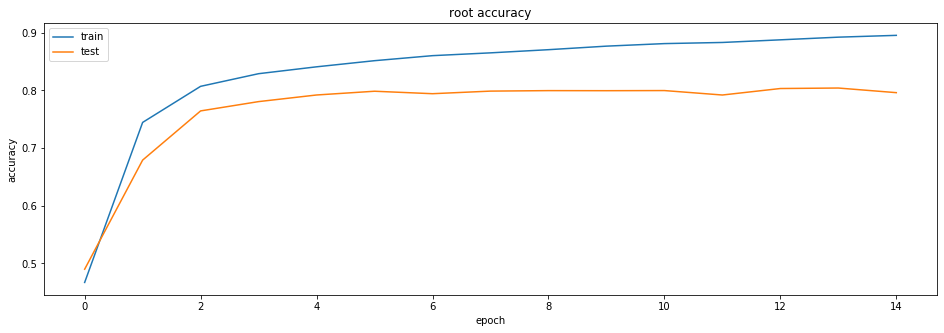

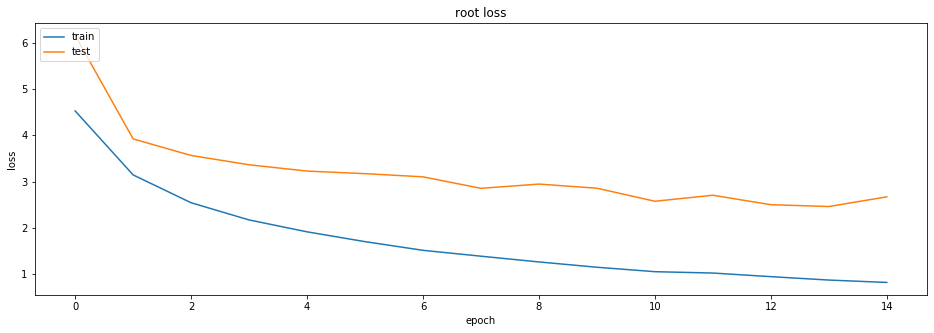

In [301]:
plt.figure(figsize=(16,5))
# summarize history for accuracy
plt.plot(callback_history.history['root_output_accuracy'])
plt.plot(callback_history.history['val_root_output_accuracy'])
plt.title('root accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.figure(figsize=(16,5))
# summarize history for loss
plt.plot(callback_history.history['loss'])
plt.plot(callback_history.history['val_loss'])
plt.title('root loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Post Processing

Build function to transform Root + Quality -> Full Chord

In [324]:
def Chordify(root = 'N', bass = 'null', triad = 'null', fourth = 'null', unknown = 'null'):
    if root == 'N': return root
    inverse = ''
    chord = root
    
    if triad != 'Major' or (fourth != 'N' and fourth != 'X' and fourth != 'null'):
        chord += ':'
    
    if triad == 'Dim':
        chord += 'dim'
        
    if triad == 'Aug':
        chord += 'aug'
    
    if triad == 'Sus2':
        chord += 'sus2'
        
    if triad == 'Sus4':
        chord += 'sus4'
    
    if fourth == 'minor7':
        chord += 'min7'
    elif triad == 'Minor':
        chord += 'min'
        
    if fourth == 'dominant7':
        chord += '7'
    
    if fourth == 'major7':
        chord += 'maj7'
        
    if fourth == 'major6':
        chord += 'maj6'
    
    if bass != 'null':
        if root != bass:
            semitones = (12 - ChordLib[root]) - (12 - ChordLib[bass])
            if semitones < 0:
                semitones += 12
            if semitones != 0:
                if semitones == 2:
                    inverse = '/2'
                elif semitones == 3:
                    inverse = '/b3'
                elif semitones == 4:
                    inverse = '/3'
                elif semitones == 5:
                    inverse = '/4'
                elif semitones == 6:
                    inverse = '/b5'
                elif semitones == 7:
                    inverse = '/5'
                elif semitones == 8:
                    inverse = '/6'
                elif semitones == 9:
                    inverse = '/b7'
                elif semitones == 10:
                    inverse = '/7'
                elif semitones == 11:
                    inverse = '/#7'
            chord += inverse
    return chord

Sooth results by removing chords appearing for few frames ~= miliseconds

In [303]:
min_frames = 3

# estimated_chord_list
# estimated_quality_list

#pass through data
previous_seen_chord = estimated_chord_list[0]
previous_chord = estimated_chord_list[0]
appearances = 1
count = 1
for chord in estimated_chord_list[1:]:
    if previous_chord != chord:
        previous_chord = chord
        if appearances <= min_frames:
            for i in range(count-appearances, count):
                estimated_chord_list[i] = previous_seen_chord
        else:
            previous_seen_chord = chord
        #new chord -> appearances = 1
        appearances = 1
    else:    
        appearances += 1
                
    count += 1

chordlist = pd.Series(estimated_chord_list, name='Root', index=list(range(0, len(estimated_chord_list))))
df_predictions.update(chordlist)

In [ ]:
#pass through data
previous_chord = df_predictions['Root'][0]
count = 1
appearances = 1
for index, chord, triad, fourth in df_predictions[1:].itertuples():
    if previous_chord != chord:
        previous_chord = chord
        max_q = max(qualities, key=qualities.get)
        for i in range(count-appearances, count):
            estimated_triad_list[i] = np.array(max_q, dtype=int)
        qualities.clear()
        qualities = {tuple(quality) : 1}
        appearances = 1
    else:
        appearances += 1
        if tuple(quality) in qualities.keys():
            qualities[tuple(quality)] += 1
        else:
            qualities[tuple(quality)] = 1
    count += 1

qualitylist = pd.Series(estimated_quality_list.tolist(), name='Quality', index=list(range(0, len(estimated_quality_list.tolist()))))
df_predictions.update(qualitylist)

In [325]:
#segments of audio data
segments = Timestamps['The Beatles'][album_test_track][test_track_no]

#annotation data
Annotation = {'Starts' : [], 'Ends' : [], 'Chord' : []}

#first chord
Annotation['Chord'].append(df_predictions['Root'][0])
Annotation['Starts'].append(0.0)

#rest of the predictions
step = 1
current_chord = df_predictions['Root'][0]
for time in segments:
    chord = df_predictions['Root'][step]
    triad = df_predictions['Triad'][step]
    fourth = df_predictions['Fourth'][step]
    if current_chord != chord:
        Annotation['Ends'].append(time)
        Annotation['Chord'].append(Chordify(root=chord, triad=triad))
        Annotation['Starts'].append(time)
        current_chord = chord
    step+=1
Annotation['Ends'].append(time)

In [326]:
Annotation_df = pd.DataFrame(data=Annotation)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(Annotation_df)

,Starts,Ends,Chord
0,0.000000,0.371519,N
1,0.371519,4.643991,C:
2,4.643991,7.616145,E
3,7.616145,11.331338,C
4,11.331338,19.597642,E
5,19.597642,22.662676,C:sus4
6,22.662676,27.771066,E
7,27.771066,28.421224,D:min
8,28.421224,31.393379,C
9,31.393379,51.826939,E


In [194]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(Chordlab['The Beatles'][album_test_track][test_track_no])

,Starts,Ends,Chord
0,0.061934,0.445329,N
1,0.445329,3.915659,C
2,3.915659,7.414302,E:min
3,7.414302,10.866452,C
4,10.866452,14.318603,E:min
5,14.318603,19.642119,E:min
6,19.642119,22.303878,C
7,22.303878,23.210503,E:min
8,23.210503,27.513015,E:min
9,27.513015,28.406163,E:min/b7


## MIREX Metrics

In [327]:
# delete inversion tool for accuracy
def delete_inversion(chord):
    if chord.find('/') != -1:
        chord, _ = chord.split('/')
    return chord

In [328]:
times = Timestamps[Artist][album_test_track][test_track_no]
df_rows = Chordlab[Artist][album_test_track][test_track_no].itertuples()
index = 0
max_len = len(Chordlab[Artist][album_test_track][test_track_no])
segments_true_chords = []
row = next(df_rows)
for timestamp in times:
    if ((index + 1) < max_len) & (timestamp >= row[2]):
        index += 1
        row = next(df_rows)
    segments_true_chords.append(row[3])

In [331]:
#CSR
CSR = 0

#segments of audio data
segments = Timestamps[Artist][album_test_track][test_track_no]

#compute total time of correct estimations
step = 0
prev_timing = 0
total_time_of_correct_estimation = 0
for time in segments:
    true_chord = segments_true_chords[step]
    estimated_chord = Chordify(root=df_predictions['Root'][step], triad=df_predictions['Triad'][step])
    if (estimated_chord == delete_inversion(true_chord)):
        total_time_of_correct_estimation += time - prev_timing
    prev_timing = time
    step += 1

#total time of segments        
total_time_of_segments = Timestamps[Artist][album_test_track][test_track_no][-1]

#CSR
CSR = total_time_of_correct_estimation / total_time_of_segments
print ("Accuracy Achieved by MIREX metric CSR = % 3.3f %%" %(CSR*100))

Accuracy Achieved by MIREX metric CSR =  54.659 %
